In [1]:
%matplotlib inline 
# %config InlineBackend.figure_format = 'retina'

In [2]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import nawrapper as nw
import nawrapper.maptools as maptools
from astropy.io import fits
import os

ImportError: libimf.so: cannot open shared object file: No such file or directory

In [3]:
map_dir = '/global/project/projectdirs/cmb/data/planck2018/pr3/frequencymaps/'
mask_dir = '/global/project/projectdirs/act/data/planck/maskMaps/'
beam_dir = f'/global/project/projectdirs/act/data/planck//BeamWf_HFI_R3.01/'
freq1, freq2 = '143', '143'

# maps and masks with _raw are those which have not been proprocessed
maps_1_raw, masks_1_raw, maps_2_raw, masks_2_raw, beams = \
    nw.planck.load_planck_half_missions(
        map_dir=map_dir, mask_dir=mask_dir, beam_dir=beam_dir, 
        freq1=freq1, freq2=freq2)

{'pol_efficiency': {'100': 0.9995, '143': 0.999, '217': 0.999}, 'nside': 2048, 'lmax': 2508}


/global/homes/x/xzackli/.conda/envs/ps/lib/python3.6/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [4]:
pol_eff_1 = nw.planck.param_2018['pol_efficiency'][freq1]
pol_eff_2 = nw.planck.param_2018['pol_efficiency'][freq2]

maps_1, masks_1 = nw.planck.preprocess_maps(
    maps_1_raw, masks_1_raw, (maps_1_raw[0] < -1e30), pol_eff_1, 2048)
maps_2, masks_2 = nw.planck.preprocess_maps(
    maps_2_raw, masks_2_raw, (maps_2_raw[0] < -1e30), pol_eff_2, 2048)

m1 = nw.namap_hp(
    maps=maps_1, masks=masks_1, 
    beams=beams, unpixwin=True)
m2 = nw.namap_hp(
    maps=maps_2, masks=masks_2, 
    beams=beams, unpixwin=True)

Creating a healpix namap. temperature: True, polarization: True
Including the healpix pixel window function.
Computing spherical harmonics.

Creating a healpix namap. temperature: True, polarization: True
Including the healpix pixel window function.
Computing spherical harmonics.



In [5]:
bins = nw.get_unbinned_bins(nw.planck.param_2018['lmax'])
SCRATCH = os.path.expandvars('$SCRATCH')
## uncomment to recompute
# mc = nw.mode_coupling(m1, m2, bins)
# mc.write_to_dir(os.path.join(SCRATCH,'mcm/143x143'))
mc = nw.mode_coupling(mcm_dir=os.path.join(SCRATCH,'mcm/143x143'))

In [6]:
planck_project = '/global/common/software/act/ps/src/PSpipe/project/Planck/'
pl = nw.planck.PlanckCov(
    ellspath=f'{planck_project}/planck_spectra/vec_all_spectra.dat',
    clpath='data/planck/data_extracted.dat',
    covpath='data/planck/covmat.dat'
    )
ell, cl, err, _  = pl.get_subcov('TT_143x143', debug=True)

binleft, binright = np.genfromtxt(
    planck_project + '/planck_spectra/binused.dat',
    unpack=True, usecols=(0,1), dtype=((int), (int)))

TT_143x143 136 335


TT_143x143 136 335
TE_143x143 1810 2009
EE_143x143 1048 1247


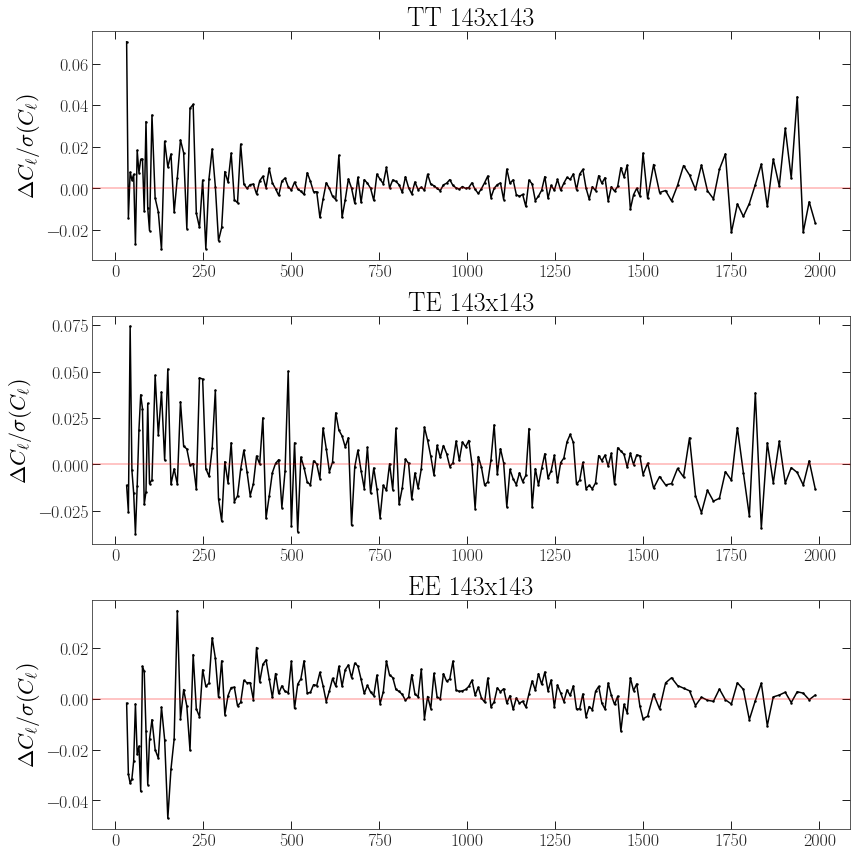

In [7]:
Cl12 = nw.compute_spectra(m1, m2, mc=mc)
Cb = nw.bin_spec_dict(Cl12, binleft, binright, nw.planck.param_2018['lmax'])

fig, axes = plt.subplots(3,1,figsize=(12,12))
for ax, spec in zip(axes, ['TT', 'TE', 'EE']):
    lb = Cb['ell']
    
    ell, cl, err, subcov  = pl.get_subcov(
        f'{spec}_{freq1}x{freq2}', debug=True)
    dl_ref_fac = ell*(ell+1)/(2*np.pi)
    ref_filt = np.in1d(lb, ell)
    if spec == 'TE':
        diy_spec = (Cb['TE'][ref_filt] + Cb['ET'][ref_filt])/ 2.0
    else:
        diy_spec = Cb[spec][ref_filt]
    ax.plot(ell, (diy_spec - (cl)) / (err), 'k.-', label=spec)
    ax.axhline(0, color='red', alpha=0.3)
    ax.set_ylabel(r'$\Delta C_{\ell} / \sigma(C_{\ell})$')
    ax.set_title(f'{spec} {freq1}x{freq2}')
plt.tight_layout()

In [8]:
fg_dir = '/global/project/projectdirs/act/data/planck/ffp8/fg/'

fg_files = {
    'faintirps': 'COM_SimMap_faintirps-ffp10-skyinbands-143_4096_R3.00_full.fits',
    'faintradiops' : 'COM_SimMap_faintradiops-ffp10-skyinbands-143_4096_R3.00_full.fits',
    'kineticsz' : 'COM_SimMap_kineticsz-ffp10-skyinbands-143_2048_R3.00_full.fits',
    'thermalsz' : 'COM_SimMap_thermalsz-ffp10-skyinbands-143_2048_R3.00_full.fits'
}

faintirps = hp.read_map(os.path.join(fg_dir,fg_files['faintirps']))
faintradiops = hp.read_map(os.path.join(fg_dir,fg_files['faintradiops']))
faintirps = hp.ud_grade(faintirps, 2048)
faintradiops = hp.ud_grade(faintradiops, 2048)

kineticsz = hp.read_map(os.path.join(fg_dir,fg_files['kineticsz']))
thermalsz, h = hp.read_map(os.path.join(fg_dir,fg_files['thermalsz']), h=True)

tot_fg =  thermalsz + kineticsz + faintirps + faintradiops
tot_fg = hp.sphtfunc.smoothing(tot_fg, beam_window=beams[0])

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Using provided beam window function
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [9]:
def load_ffp_halfmission_maps(num, mode='ffp10', freq='143'):
    
    # FFP8
    if mode == 'ffp8':
        noise_dir = '/project/projectdirs/act/data/planck/ffp8/mc_noise/' + freq
        cmb_dir = '/project/projectdirs/cmb/data/planck2015/ffp8.1/mc_cmb/' + freq
        str_num = str(num).zfill(5)    
        noise_file_1 = os.path.join(
            noise_dir, 'ffp8_noise_'+freq+'_hm1_map_mc_' + str_num  + '.fits')
        noise_file_2 = os.path.join(
            noise_dir, 'ffp8_noise_'+freq+'_hm2_map_mc_' +  str_num + '.fits')
        cmb_file = os.path.join(
            cmb_dir, 'ffp8_cmb_scl_'+freq+'_full_map_mc_' + str_num + '.fits')

    elif mode == 'ffp10':
        noise_dir = '/project/projectdirs/cmb/data/planck2018/ffp10/mc_noise/' + freq
        cmb_dir = '/project/projectdirs/cmb/data/planck2018/ffp10/mc_cmb/' + freq
        noise_file_1 = os.path.join(
            noise_dir, 'ffp10_noise_' + freq + '_hm1_map_mc_' + str(num).zfill(5) + '.fits')
        noise_file_2 = os.path.join(
            noise_dir, 'ffp10_noise_' + freq + '_hm2_map_mc_' +  str(num).zfill(5) + '.fits')
        cmb_file = os.path.join(
            cmb_dir, 'febecop_ffp10_lensed_scl_cmb_' + freq + '_mc_' + str(num).zfill(4)  + '.fits')
        
    
    pol_eff_1 = nw.planck.param_2018['pol_efficiency'][freq1]
    pol_eff_2 = nw.planck.param_2018['pol_efficiency'][freq2]

    noise_map_1 = hp.read_map(noise_file_1, field=(0,1,2), verbose=False)
    noise_map_2 = hp.read_map(noise_file_2, field=(0,1,2), verbose=False)
    cmb_map = hp.read_map(cmb_file, field=(0,1,2), verbose=False)
    cmb_map[0] += tot_fg
    
    maps_1, masks_1 = nw.planck.preprocess_maps(
        cmb_map + noise_map_1, masks_1_raw, 
        (noise_map_1[0] < -1e30), pol_eff_1, 2048)
    maps_2, masks_2 = nw.planck.preprocess_maps(
        cmb_map + noise_map_2, masks_2_raw, 
        (noise_map_2[0] < -1e30), pol_eff_2, 2048)
    
    m1_s = nw.namap_hp(
        maps=maps_1, masks=masks_1, 
        beams=beams, unpixwin=True, verbose=False)
    m2_s = nw.namap_hp(
        maps=maps_2, masks=masks_2, 
        beams=beams, unpixwin=True, verbose=False)
    
    return m1_s, m2_s

In [10]:
m1_sim, m2_sim = load_ffp_halfmission_maps(2)
Cl12 = nw.compute_spectra(m1_sim, m2_sim, mc=mc)
Cb = nw.bin_spec_dict(Cl12, binleft, binright, nw.planck.param_2018['lmax'])

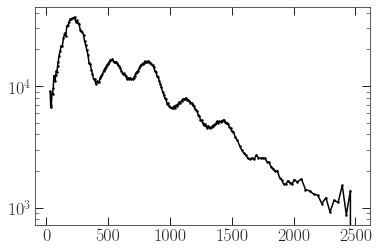

In [11]:
plt.plot(Cb['ell'], Cb['TT'] * Cb['ell']**2)
plt.yscale('log')

TT_143x143 136 335
TE_143x143 1810 2009
EE_143x143 1048 1247


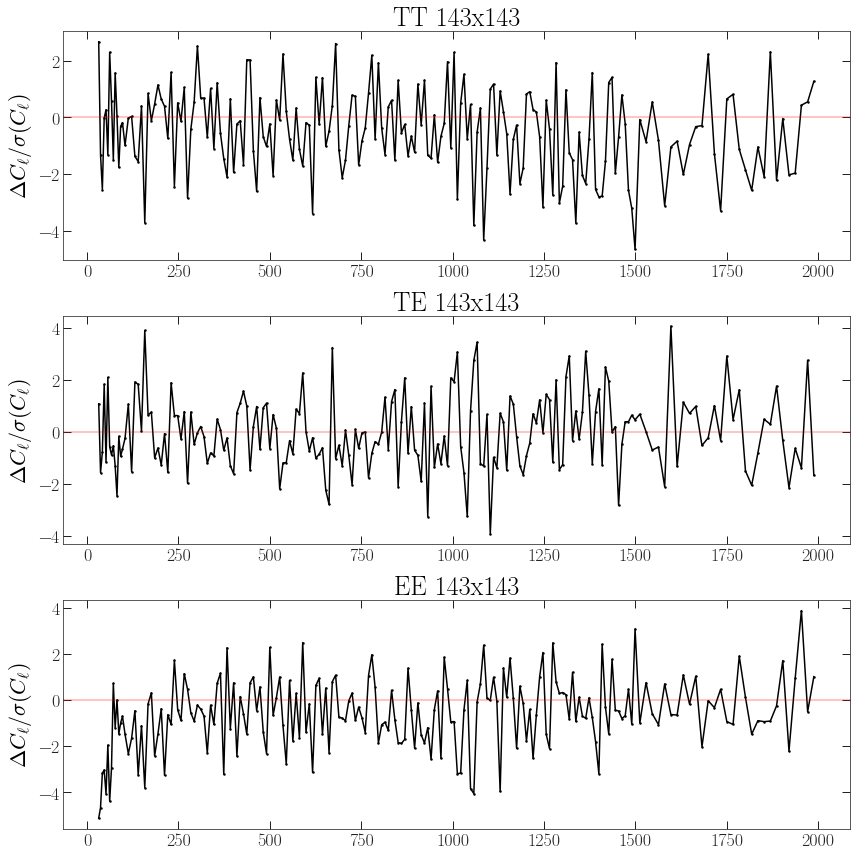

In [12]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
for ax, spec in zip(axes, ['TT', 'TE', 'EE']):
    lb = Cb['ell']
    
    ell, cl, err, subcov  = pl.get_subcov(
        f'{spec}_{freq1}x{freq2}', debug=True)
    dl_ref_fac = ell*(ell+1)/(2*np.pi)
    ref_filt = np.in1d(lb, ell)
    if spec == 'TE':
        diy_spec = (Cb['TE'][ref_filt] + Cb['ET'][ref_filt])/ 2.0
    else:
        diy_spec = Cb[spec][ref_filt]
    ax.plot(ell, (diy_spec - (cl)) / (err), 'k.-', label=spec)
    ax.axhline(0, color='red', alpha=0.3)
    ax.set_ylabel(r'$\Delta C_{\ell} / \sigma(C_{\ell})$')
    ax.set_title(f'{spec} {freq1}x{freq2}')
plt.tight_layout()

In [ ]:
from tqdm import tqdm
import json

for i in tqdm(range(100)): 
    m1_sim, m2_sim = load_ffp_halfmission_maps(i)
    Cl12 = nw.compute_spectra(m1_sim, m2_sim, mc=mc)
    Cb = nw.bin_spec_dict(Cl12, binleft, binright, nw.planck.param_2018['lmax'])
    np.save(os.path.join(SCRATCH,'Cb_ffp', f'{i}_Cb.npy'),Cb)

  4%|▍         | 4/100 [06:33<2:37:35, 98.50s/it]